In [1]:
# Install torchsummary if not installed
# Import essential libraries
#pip install torch torchvision torchaudio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Define Transformation
transform = transforms.Compose(
    [
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [3]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# Define your data directories (Make sure these paths are correct)
train_dir = 'train2'   # Path to training images
valid_dir = 'valid2'   # Path to validation images
test_dir = 'test2'     # Path to testing images

# Check if the directories exist
print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(valid_dir))
print("Test directory exists:", os.path.exists(test_dir))

# If the directories exist, load the datasets
if os.path.exists(train_dir) and os.path.exists(valid_dir) and os.path.exists(test_dir):
    # Define the necessary transform (assuming 'transform' is already defined)
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets
    train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform)
    val_set = torchvision.datasets.ImageFolder(valid_dir, transform=transform)
    test_set = torchvision.datasets.ImageFolder(test_dir, transform=transform)

    # Optional: print the dataset sizes
    print(f"Train set size: {len(train_set)}")
    print(f"Validation set size: {len(val_set)}")
    print(f"Test set size: {len(test_set)}")
else:
    print("One or more dataset directories do not exist. Please verify the paths.")

Train directory exists: True
Validation directory exists: True
Test directory exists: True
Train set size: 2110
Validation set size: 718
Test set size: 352


Train set size: 2110


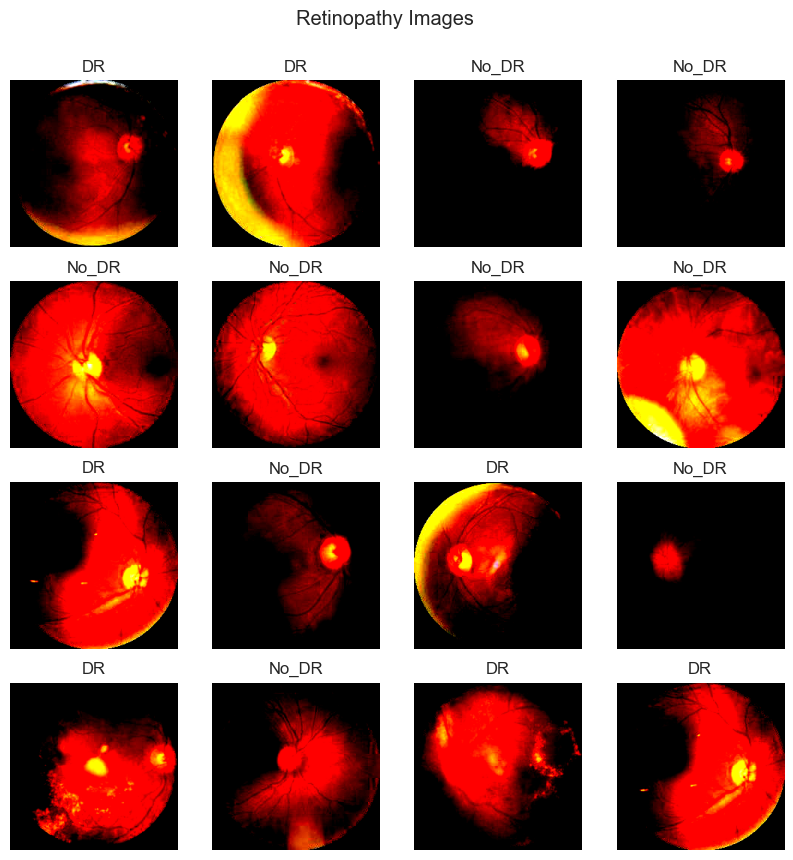

In [4]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy

# Check if the directory exists
if os.path.exists(train_dir):
    # Define the transform
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load train set
    train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform)
    print(f"Train set size: {len(train_set)}")
else:
    print("Train directory does not exist. Please verify the path.")

# Visualizing some images from Trainset
if 'train_set' in locals():  # Check if train_set is defined
    CLA_label = {
        0: 'DR',
        1: 'No_DR',
    }

    figure = plt.figure(figsize=(10, 10))
    cols, rows = 4, 4
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_set), size=(1,)).item()  # Randomly pick an image
        img, label = train_set[sample_idx]  # Get the image and label
        figure.add_subplot(rows, cols, i)
        plt.title(CLA_label[label])
        plt.axis("off")
        img_np = img.numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change shape
        img_valid_range = np.clip(img_np, 0, 1)  # Clip pixel values to [0, 1]
        plt.imshow(img_valid_range)

    plt.suptitle('Retinopathy Images', y=0.95)
    plt.show()
else:
    print("train_set is not loaded. Make sure the dataset is loaded correctly.")

In [5]:

# Import and load Train, Validation, and Test sets
batch_size = 64

# Create DataLoaders
if 'train_set' in locals() and 'val_set' in locals() and 'test_set' in locals():
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    print("DataLoaders created successfully.")
else:
    print("Failed to create DataLoaders. Ensure that the datasets are loaded correctly.")

DataLoaders created successfully.


In [6]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64



In [7]:
'''This function can be useful in determining the output size of a convolutional layer,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Function to find the output shape after convolution
def findConv2dOutShape(H, W, conv):
    with torch.no_grad():
        dummy_input = torch.zeros(1, conv.in_channels, H, W)
        output = conv(dummy_input)
        return output.shape[2], output.shape[3]

# Depthwise Separable Convolution
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.pointwise(self.depthwise(x))

# Define Architecture For Retinopathy Model
class CNN_Retino_Xception(nn.Module):

    def __init__(self, params):
        super(CNN_Retino_Xception, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # CNN Layers
        self.conv1 = DepthwiseSeparableConv(Cin, init_f)
        h, w = findConv2dOutShape(Hin, Win, self.conv1)

        self.conv2 = DepthwiseSeparableConv(init_f, 2 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv2)

        self.conv3 = DepthwiseSeparableConv(2 * init_f, 4 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv3)

        self.conv4 = DepthwiseSeparableConv(4 * init_f, 8 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv4)

        # Compute the flatten size
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = self.conv1(X)
        X = F.max_pool2d(X, 2, 2)
        X = self.conv2(X)
        X = F.max_pool2d(X, 2, 2)
        X = self.conv3(X)
        X = F.max_pool2d(X, 2, 2)
        X = self.conv4(X)
        X = F.max_pool2d(X, 2, 2)
        
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)


In [9]:
import torch
import torch.nn as nn

# Define depthwise separable convolution module
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.activation(x)

# Define the modified CNN model class
class CNN_Retino_Xception(nn.Module):
    def __init__(self, params):
        super(CNN_Retino_Xception, self).__init__()
        
        # Convolutional layers
        self.conv1 = DepthwiseSeparableConv(params["shape_in"][0], params["initial_filters"])
        self.conv2 = DepthwiseSeparableConv(params["initial_filters"], params["initial_filters"] * 2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(params["initial_filters"] * 2 * 63 * 63, params["num_fc1"])
        self.fc2 = nn.Linear(params["num_fc1"], params["num_classes"])
        
        # Dropout layer
        self.dropout = nn.Dropout(p=params["dropout_rate"])
        
    def forward(self, x):
        identity = x  # Save input for residual connection
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        # Residual connection
        if x.shape == identity.shape:  # Ensure the shapes match for the addition
            x += identity
        
        # Flatten for fully connected layer
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Model parameters
params_model = {
    "shape_in": (3, 255, 255),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.15,
    "num_classes": 2
}

# Instantiate the model
Retino_model = CNN_Retino_Xception(params_model)

# Define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Retino_model = Retino_model.to(device)

# Print model architecture for verification
print(Retino_model)


CNN_Retino_Xception(
  (conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
    (pointwise): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU()
  )
  (conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
    (pointwise): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=63504, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)


In [10]:
#pip install torchsummary
from torchsummary import summary

# Model Summary for CNN_Retino
summary(Retino_model, input_size=(3, 255, 255), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 255, 255]              30
            Conv2d-2          [-1, 8, 255, 255]              32
              ReLU-3          [-1, 8, 255, 255]               0
DepthwiseSeparableConv-4          [-1, 8, 255, 255]               0
         MaxPool2d-5          [-1, 8, 127, 127]               0
            Conv2d-6          [-1, 8, 127, 127]              80
            Conv2d-7         [-1, 16, 127, 127]             144
              ReLU-8         [-1, 16, 127, 127]               0
DepthwiseSeparableConv-9         [-1, 16, 127, 127]               0
        MaxPool2d-10           [-1, 16, 63, 63]               0
           Linear-11                  [-1, 100]       6,350,500
          Dropout-12                  [-1, 100]               0
           Linear-13                    [-1, 2]             202
Total params: 6,350,988
Trainab

In [11]:
loss_func = nn.NLLLoss(reduction="sum")

In [12]:
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [13]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [14]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import copy
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import timm  # Import timm for the Xception model

# Define transformations for training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root="./train2", transform=train_transform)
val_dataset = datasets.ImageFolder(root="./valid2", transform=val_transform)

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained Xception model
model = timm.create_model('xception', pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

# Define loss function, optimizer, and learning rate scheduler
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Function to get the current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Function for calculating loss and metrics for an epoch
def loss_epoch(model, loss_func, data_loader, optimizer=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(data_loader.dataset)

    for xb, yb in data_loader:
        xb, yb = xb.to(device), yb.to(device)

        outputs = model(xb)
        loss = loss_func(outputs, yb)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_metric += torch.sum(preds == yb).item()

    epoch_loss = running_loss / len_data
    epoch_metric = running_metric / len_data

    return epoch_loss, epoch_metric

# Training and validation function with early stopping
def train_val(model, params, patience=5):
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]

    # History of loss and accuracy
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience_counter = 0  # Counter for early stopping

    for epoch in tqdm(range(epochs)):
        current_lr = get_lr(opt)

        # Training
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
            loss_history["val"].append(val_loss)
            metric_history["val"].append(val_metric)

        # Check if validation loss improved
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weight_path)
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        lr_scheduler.step(val_loss)

    model.load_state_dict(best_model_wts)

    return loss_history, metric_history

# Parameters for training
params = {
    "train": train_dl,
    "val": val_dl,
    "epochs": 30,  # You can adjust this as needed
    "f_loss": loss_func,
    "optimiser": optimizer,
    "lr_change": scheduler,
    "weight_path": "xception_best_model.pth"
}

# Run the training and validation process
loss_history, metric_history = train_val(model, params)

# loss_history and metric_history contain training and validation loss and accuracy.


 40%|████      | 12/30 [3:16:12<4:54:18, 981.05s/it]

Early stopping at epoch 13


In [16]:
# Print training and validation loss and accuracy for each epoch
for epoch in range(len(loss_history["train"])):
    print(f"Epoch {epoch+1}/{params['epochs']}:")
    print(f"  Training Loss: {loss_history['train'][epoch]:.4f}, Training Accuracy: {metric_history['train'][epoch]:.4f}")
    print(f"  Validation Loss: {loss_history['val'][epoch]:.4f}, Validation Accuracy: {metric_history['val'][epoch]:.4f}")

Epoch 1/30:
  Training Loss: 0.2544, Training Accuracy: 0.9033
  Validation Loss: 0.1277, Validation Accuracy: 0.9513
Epoch 2/30:
  Training Loss: 0.0786, Training Accuracy: 0.9768
  Validation Loss: 0.2915, Validation Accuracy: 0.8969
Epoch 3/30:
  Training Loss: 0.0551, Training Accuracy: 0.9791
  Validation Loss: 0.0136, Validation Accuracy: 0.9944
Epoch 4/30:
  Training Loss: 0.0589, Training Accuracy: 0.9763
  Validation Loss: 0.0259, Validation Accuracy: 0.9889
Epoch 5/30:
  Training Loss: 0.0459, Training Accuracy: 0.9872
  Validation Loss: 0.0598, Validation Accuracy: 0.9805
Epoch 6/30:
  Training Loss: 0.0324, Training Accuracy: 0.9867
  Validation Loss: 0.0331, Validation Accuracy: 0.9889
Epoch 7/30:
  Training Loss: 0.0202, Training Accuracy: 0.9924
  Validation Loss: 0.0473, Validation Accuracy: 0.9847
Epoch 8/30:
  Training Loss: 0.0076, Training Accuracy: 0.9967
  Validation Loss: 0.0035, Validation Accuracy: 1.0000
Epoch 9/30:
  Training Loss: 0.0055, Training Accuracy: 

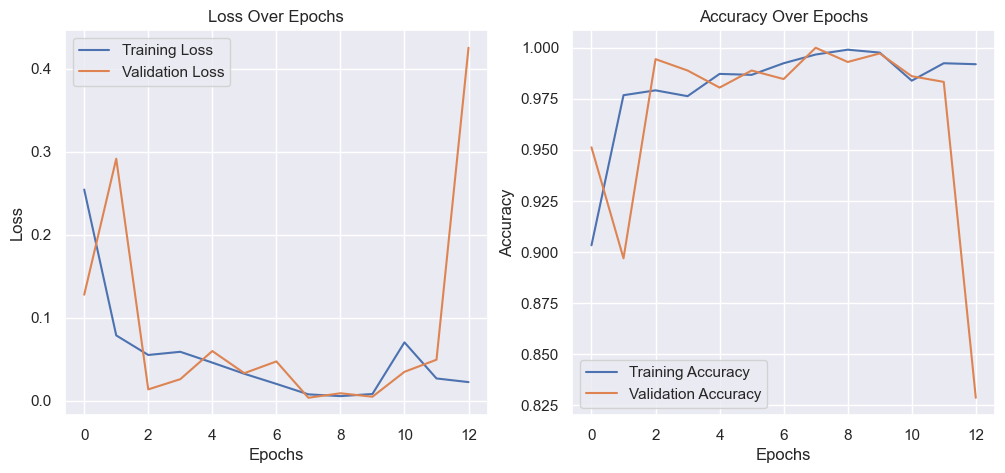

In [17]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss_history["train"], label='Training Loss')
plt.plot(loss_history["val"], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(metric_history["train"], label='Training Accuracy')
plt.plot(metric_history["val"], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import numpy as np
import timm  # Import timm for loading the Xception model

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transformation for the test dataset (same as validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Replace this path with the actual path to your test dataset
test_dataset = datasets.ImageFolder(root="./test2", transform=test_transform)

# Create DataLoader for the test dataset
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained Xception model from timm
model = timm.create_model('xception', pretrained=False)

# Modify the final fully connected (fc) layer to match the number of classes (2 in this case)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # 2 is the number of classes in your trained model
model.load_state_dict(torch.load("xception_best_model.pth"))  # Load the trained model weights
model = model.to(device)  # Send model to the appropriate device (CPU or GPU)

# Initialize variables for accuracy, precision, recall, F1 score, AUC, and specificity on the test set
all_preds = []
all_targets = []
all_probs = []
correct = 0
total = 0
model.eval()

# Perform testing
with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)

        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1)

        # Get predictions and store them along with true labels and probabilities
        preds = torch.argmax(probabilities, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())  # Store probabilities for AUC calculation
        
        correct += (preds == yb).sum().item()
        total += yb.size(0)

# Calculate test accuracy
test_accuracy = correct / total

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')

# Calculate AUC (requires one-vs-all for multiclass)
one_hot_targets = np.eye(len(np.unique(all_targets)))[all_targets]  # Convert targets to one-hot encoding
auc_score = roc_auc_score(one_hot_targets, np.array(all_probs), multi_class='ovr')  # Calculate AUC for multiclass

# Calculate specificity for each class
cm = confusion_matrix(all_targets, all_preds)
specificities = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, 0), i, 1))  # True negatives
    fp = np.sum(np.delete(cm, i, 0)[:, i])  # False positives
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

# Print metrics
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'AUC Score: {auc_score * 100:.2f}%')

# Print average specificity over all classes
avg_specificity = np.mean(specificities)
print(f'Average Specificity: {avg_specificity * 100:.2f}%')


Test Accuracy: 98.17%
Precision: 98.17%
Recall: 98.17%
F1 Score: 98.17%
AUC Score: 99.82%
Average Specificity: 97.47%


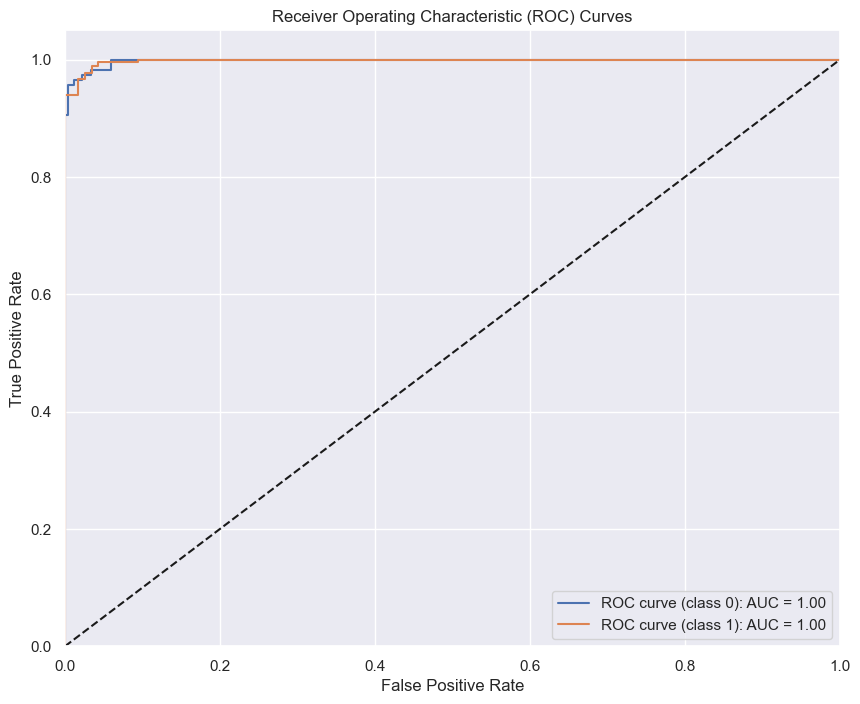

In [19]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve, auc

# AUC (requires one-vs-all for multiclass)
one_hot_targets = np.eye(len(np.unique(all_targets)))[all_targets]
auc_score = roc_auc_score(one_hot_targets, np.array(all_probs), multi_class='ovr')

# Calculate the ROC curve for each class
n_classes = one_hot_targets.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot_targets[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}): AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


True Positives (TP): 265
False Positives (FP): 5
False Negatives (FN): 2
True Negatives (TN): 111


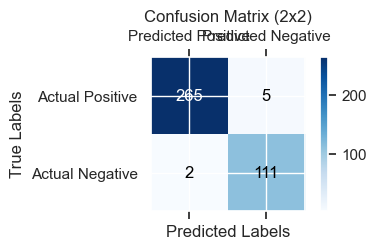

In [20]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Create confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Extract TP, FP, TN, FN for binary classification
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives
TP = cm[1, 1]  # True Positives

# Print the four key values
print(f'True Positives (TP): {TP}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Negatives (TN): {TN}')

# Create a 2x2 matrix for visualization
confusion_matrix_2x2 = np.array([[TP, FP],
                                  [FN, TN]])

# Display the 2x2 confusion matrix
fig, ax = plt.subplots(figsize=(4, 2))  # Adjust size here
cax = ax.matshow(confusion_matrix_2x2, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set axis labels and ticks
ax.set_xticklabels(['', 'Predicted Positive', 'Predicted Negative'])
ax.set_yticklabels(['', 'Actual Positive', 'Actual Negative'])

# Annotate each cell with numeric value
for (i, j), val in np.ndenumerate(confusion_matrix_2x2):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white' if val > confusion_matrix_2x2.max()/2 else 'black')

# Add title
plt.title('Confusion Matrix (2x2)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()


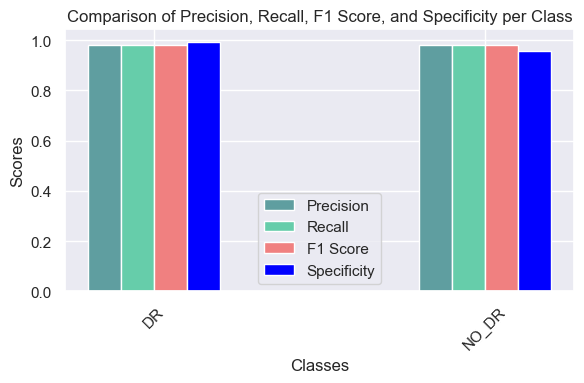

In [21]:
# Visualization with histograms
classes = test_dataset.classes  # Class names from the dataset
x = np.arange(len(classes))  # Label locations
width = 0.1  # Width of the bars

# Create subplots for the bar plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot precision, recall, f1 score, and specificity as bar charts
rects1 = ax.bar(x - width*1.5, precision, width, label='Precision', color='cadetblue')
rects2 = ax.bar(x - width/2, recall, width, label='Recall', color='mediumaquamarine')
rects3 = ax.bar(x + width/2, f1, width, label='F1 Score', color='lightcoral')
rects4 = ax.bar(x + width*1.5, specificities, width, label='Specificity', color='blue')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, F1 Score, and Specificity per Class')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [46]:
import torch

# Assuming 'model' is your ResNet model
torch.save(model.state_dict(), 'xception_best_modelnewdata.pth')


